In [ ]:
 !pip install -U lightautoml==0.3.8b1

In [2]:
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
INPUT_DIR = '/kaggle/input/ieee-fraud-detection'

# 1. Загрузка данных

In [5]:
train_transaction = pd.read_csv(f'{INPUT_DIR}/train_transaction.csv')
test_transaction = pd.read_csv(f'{INPUT_DIR}/test_transaction.csv')

train_identity = pd.read_csv(f'{INPUT_DIR}/train_identity.csv')
test_identity = pd.read_csv(f'{INPUT_DIR}/test_identity.csv')

sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объединим датасеты

In [8]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [9]:
test.rename(columns={'id-01': 'id_01', 'id-02': 'id_02', 'id-03': 'id_03', 
                                  'id-04': 'id_04', 'id-05': 'id_05', 'id-06': 'id_06', 
                                  'id-07': 'id_07', 'id-08': 'id_08', 'id-09': 'id_09', 
                                  'id-10': 'id_10', 'id-11': 'id_11', 'id-12': 'id_12', 
                                  'id-13': 'id_13', 'id-14': 'id_14', 'id-15': 'id_15', 
                                  'id-16': 'id_16', 'id-17': 'id_17', 'id-18': 'id_18', 
                                  'id-19': 'id_19', 'id-20': 'id_20', 'id-21': 'id_21', 
                                  'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24',
                                  'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 
                                  'id-28': 'id_28', 'id-29': 'id_29', 'id-30': 'id_30', 
                                  'id-31': 'id_31', 'id-32': 'id_32', 'id-33': 'id_33', 
                                  'id-34': 'id_34', 'id-35': 'id_35', 'id-36': 'id_36', 
                                  'id-37': 'id_37', 'id-38': 'id_38'}, inplace=True)

# 2. Анализ данных

**Анализ таргета**

In [9]:
count = train['isFraud'].value_counts()

print(count)

0    569877
1     20663
Name: isFraud, dtype: int64


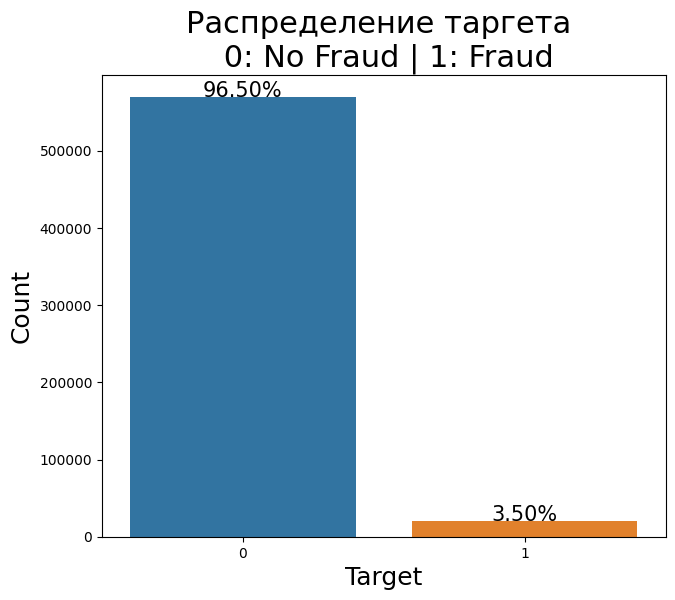

In [59]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train, )
g.set_title("Распределение таргета \n 0: No Fraud | 1: Fraud", fontsize=22)
g.set_xlabel("Target", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

**Анализ объектов-признаков**

In [10]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


Выявление разных типов (численных значений, категориальных, временные метки) значений и их распределение

In [11]:
#Наименования категориальных признаков взяты из описания данных
cat_features = ['ProductCD', 'card1','card2','card3','card4','card5','card6', 'addr1','addr2', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13','id_14','id_15',
                'id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31',
                'id_32','id_33','id_34','id_35','id_36','id_37','id_38']

num_features = [x for x in train.columns.values if x not in cat_features]  #slicing from 2 onwards ( first 2 columns are identifier and target)

features = num_features + cat_features

print('Категориальные признаки :', len(cat_features))
print('Числовые признаки : ',len(num_features))

Категориальные признаки : 49
Числовые признаки :  385


Выявление пропущенных значений

In [12]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [13]:
resumetable(train)[:20]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int64,0,2,0,0,0,0.22
2,TransactionDT,int64,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.35
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int64,0,13553,13926,2755,4663,9.97
6,card2,float64,8933,500,NaN,404.0,490.0,6.32
7,card3,float64,1565,114,150.0,150.0,150.0,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float64,4259,119,142.0,102.0,166.0,2.66


In [14]:
miss_values= train.isnull().sum()                    
percent_miss_values = (train.isnull().sum()/train.isnull().count()*100)

pd.concat([miss_values, percent_miss_values], axis=1, keys=['Пропущенные значения', '%']).transpose()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Пропущенные значения,0.0,0.0,0.0,0.0,0.0,0.0,8933.000000,1565.000000,1577.000000,4259.000000,...,450258.000000,512954.000000,517251.000000,512735.000000,449555.000000,449555.000000,449555.000000,449555.000000,449730.000000,471874.00000
%,0.0,0.0,0.0,0.0,0.0,0.0,1.512683,0.265012,0.267044,0.721204,...,76.245132,86.861855,87.589494,86.824771,76.126088,76.126088,76.126088,76.126088,76.155722,79.90551


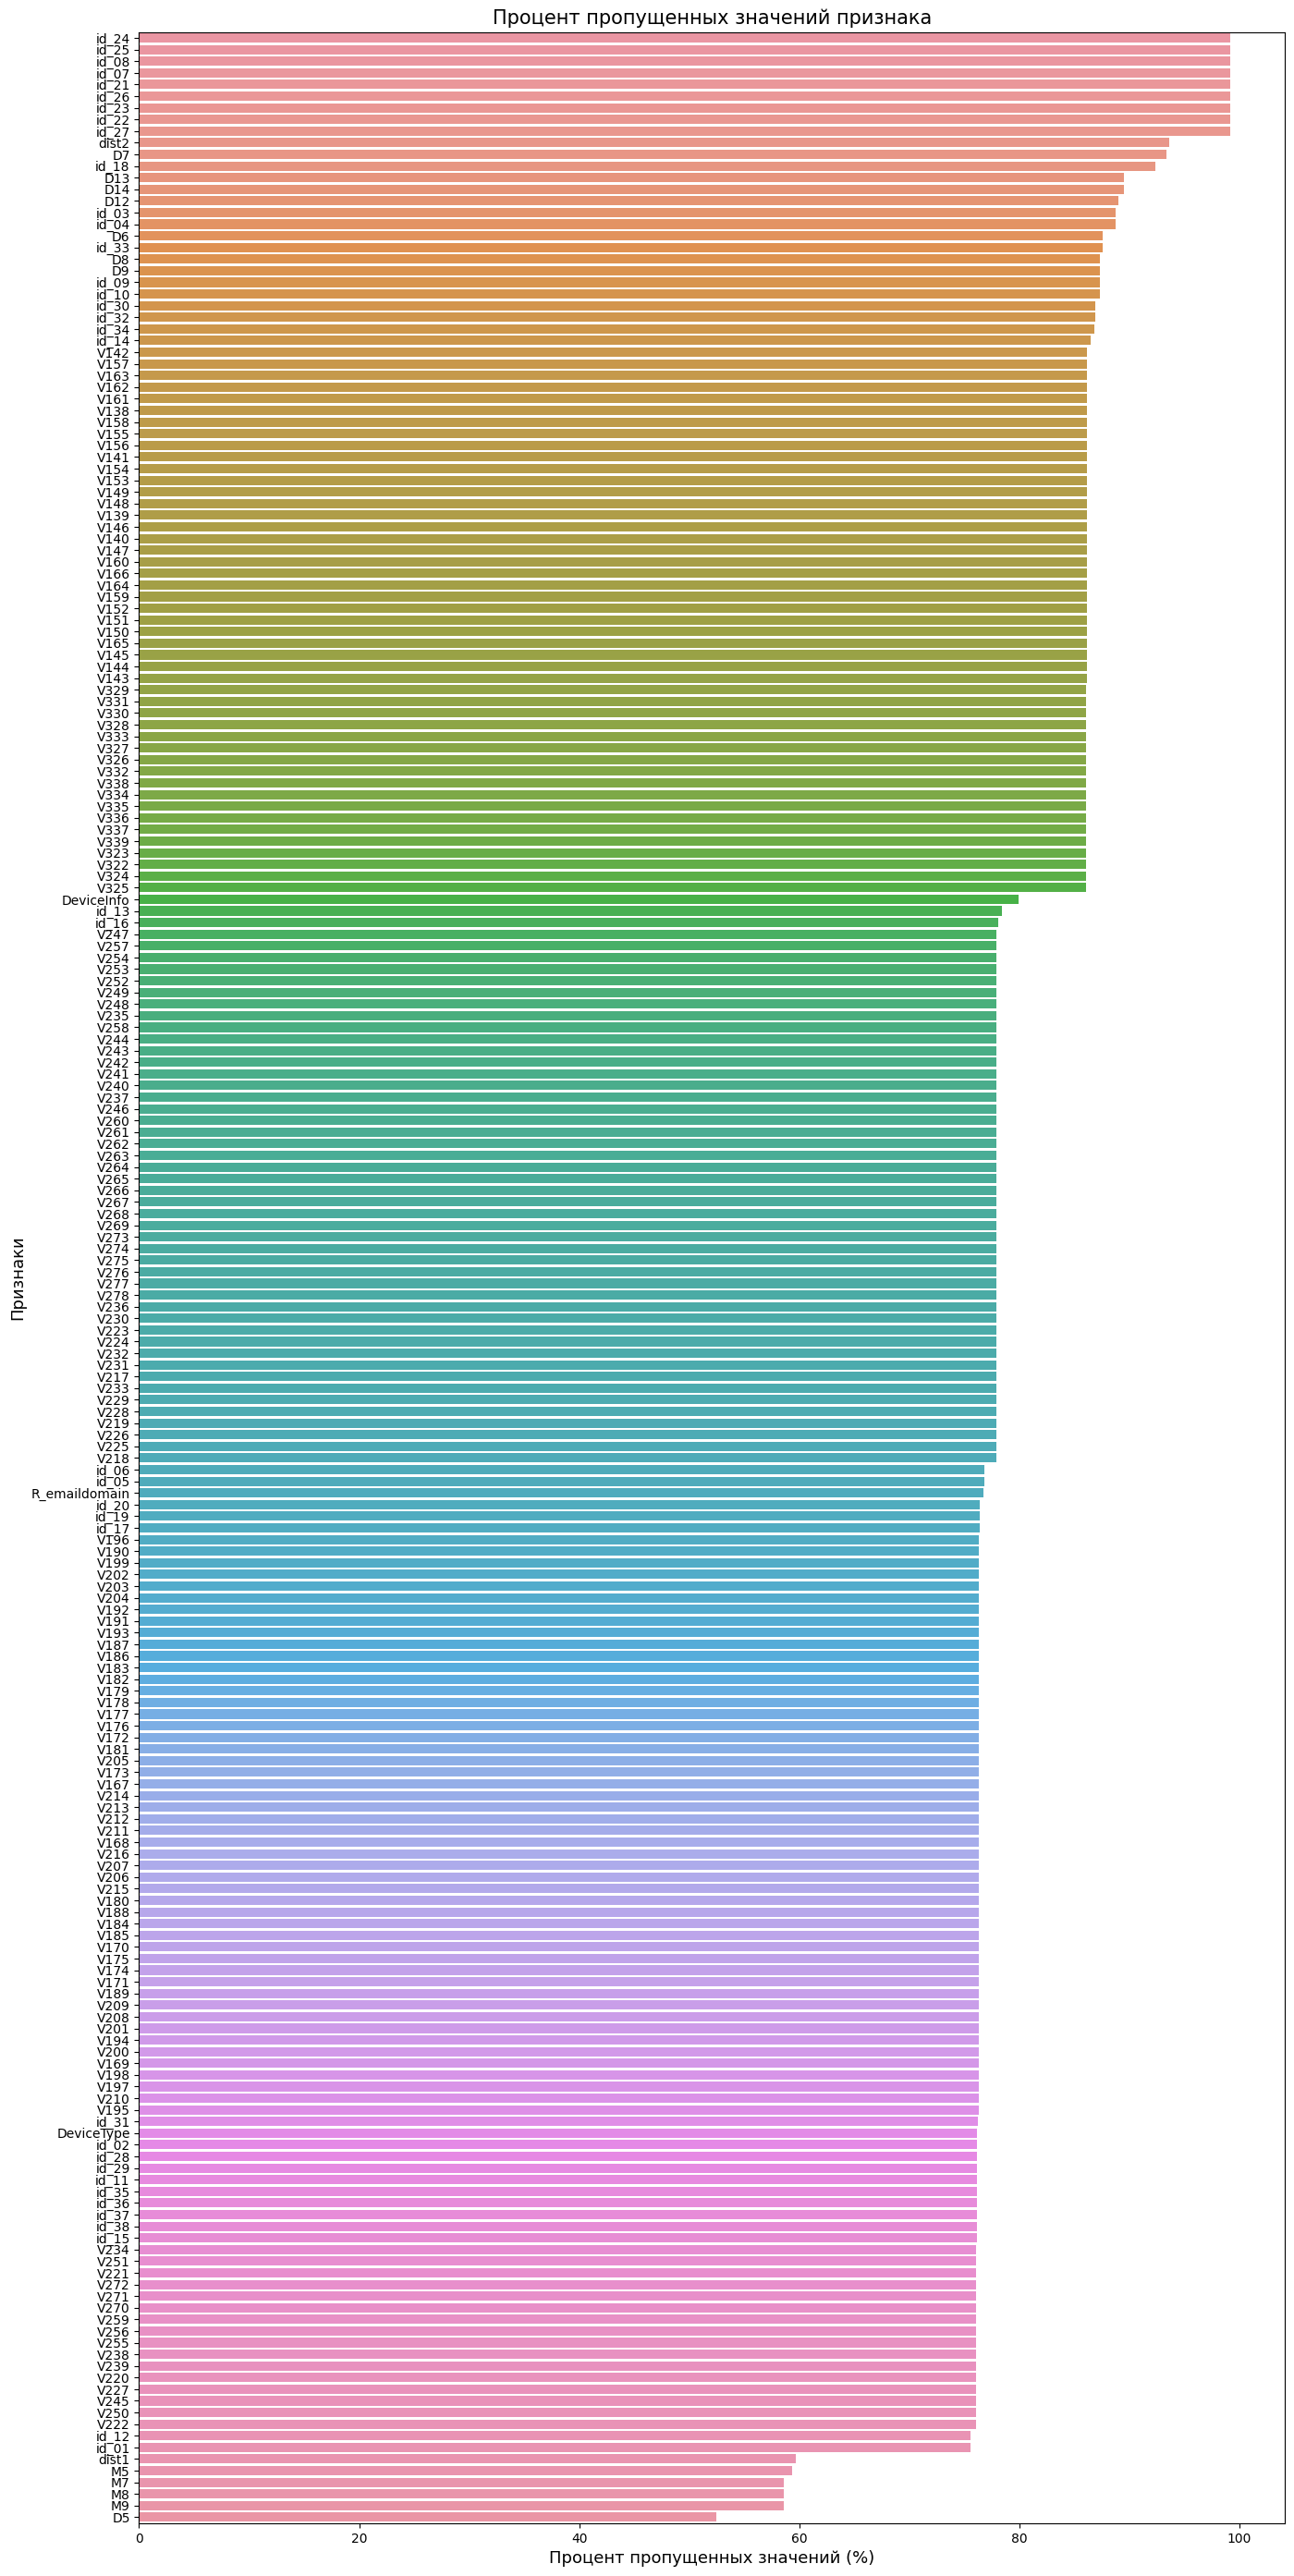

In [15]:
#Посмотрим на признаки, где более 50% пропущенных значений
missing_data = pd.concat([miss_values, percent_miss_values], axis=1, keys=['Пропущенные значения', '%'])
missing_data = missing_data[missing_data['%'] > 50].sort_values(by='%', ascending=False)

plt.figure(figsize=(16,35))
sns.barplot(y=missing_data.index, x=missing_data['%'])
plt.title('Процент пропущенных значений признака', fontsize=15)
plt.xlabel('Процент пропущенных значений (%)', fontsize=13)
plt.ylabel('Признаки', fontsize=13)
plt.show()

Выявление зависимых признаков

In [16]:
correlation_matrix = train.corr()
correlation_matrix

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,...,0.222829,0.111975,-0.015030,0.084105,-0.029004,0.052621,-0.038339,0.020672,0.013670,-0.066437
isFraud,0.014166,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,...,0.150100,0.050004,-0.041721,0.061597,0.063544,0.118409,-0.001905,0.034045,0.099587,0.069702
TransactionDT,0.998280,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,...,0.214802,0.110234,-0.011815,0.082009,-0.024249,0.051437,-0.031312,0.020372,0.017790,-0.071392
TransactionAmt,0.012025,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,...,-0.334971,-0.096851,0.076174,-0.105866,-0.031840,-0.104620,0.080110,0.016145,0.023098,-0.041851
card1,0.010122,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,...,0.018892,0.008869,0.022617,0.015917,0.044073,0.016853,0.057550,-0.010192,0.078487,-0.009524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_22,0.052621,0.118409,0.051437,-0.104620,0.016853,-0.024013,0.657624,-0.180340,0.065780,-0.291785,...,0.591957,0.130109,0.063871,0.030765,0.070591,1.000000,0.014067,0.182643,0.281324,-0.041127
id_24,-0.038339,-0.001905,-0.031312,0.080110,0.057550,0.000844,0.011953,-0.018330,-0.032398,-0.037455,...,-0.014895,0.014321,0.245221,-0.189628,0.220933,0.014067,1.000000,-0.030902,0.086002,-0.219537
id_25,0.020672,0.034045,0.020372,0.016145,-0.010192,-0.009787,0.140797,-0.042232,-0.004287,0.004896,...,0.173535,0.108161,-0.008509,-0.028451,-0.147694,0.182643,-0.030902,1.000000,0.011508,0.027603
id_26,0.013670,0.099587,0.017790,0.023098,0.078487,0.006429,0.228904,-0.089528,0.050645,-0.067406,...,0.076164,-0.048799,0.116386,0.048413,0.053721,0.281324,0.086002,0.011508,1.000000,-0.065558


isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
V44        0.260376
V86        0.251828
V87        0.251737
V170       0.249794
V147       0.242894
Name: isFraud, dtype: float64


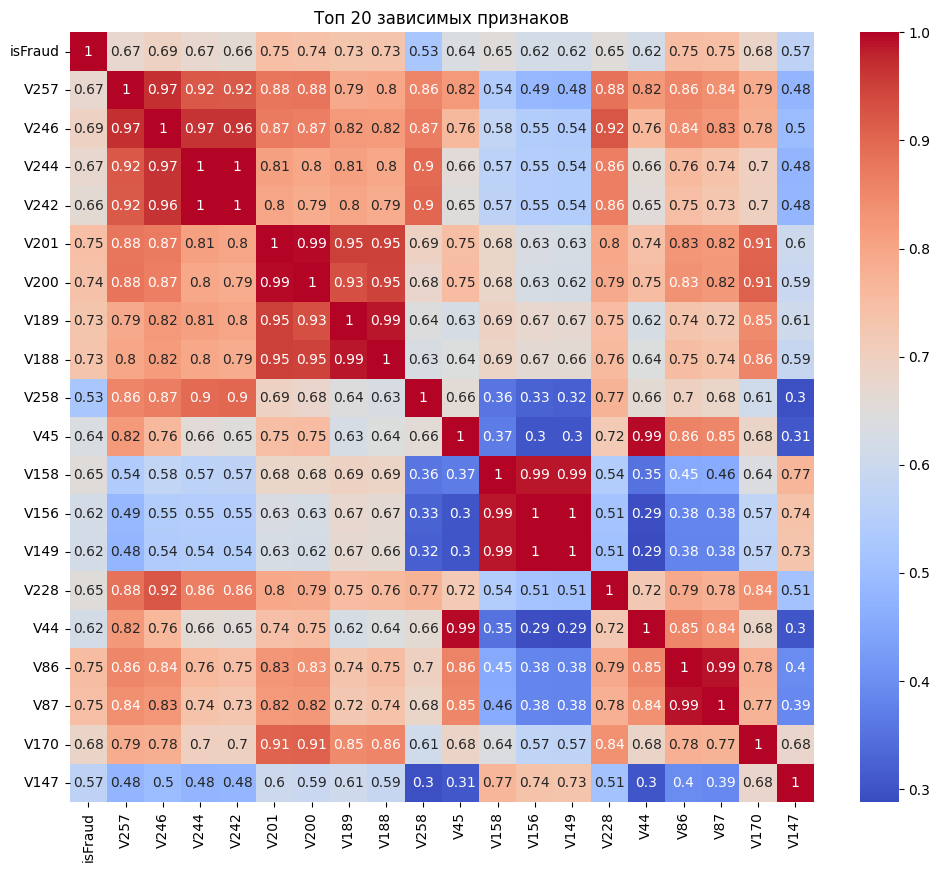

In [17]:
correlations = correlation_matrix['isFraud'].sort_values(ascending=False)
top_20_correlations = correlations[:20]

print(top_20_correlations)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[top_20_correlations.index].corr(), annot=True, cmap='coolwarm')
plt.title("Топ 20 зависимых признаков")
plt.show()

Распределение TransactionDT

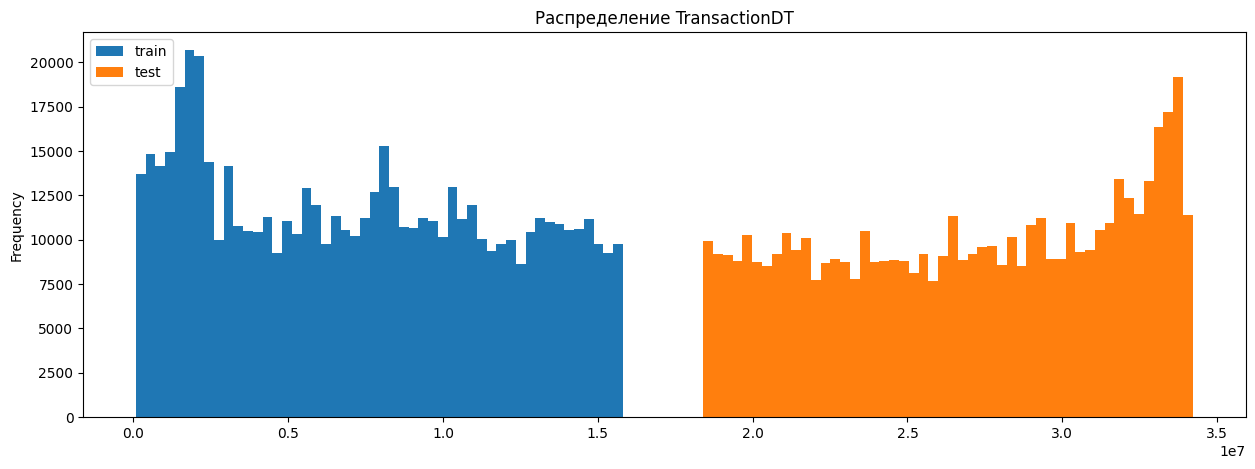

In [18]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Распределение TransactionDT')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

Распределение сумм транзакций

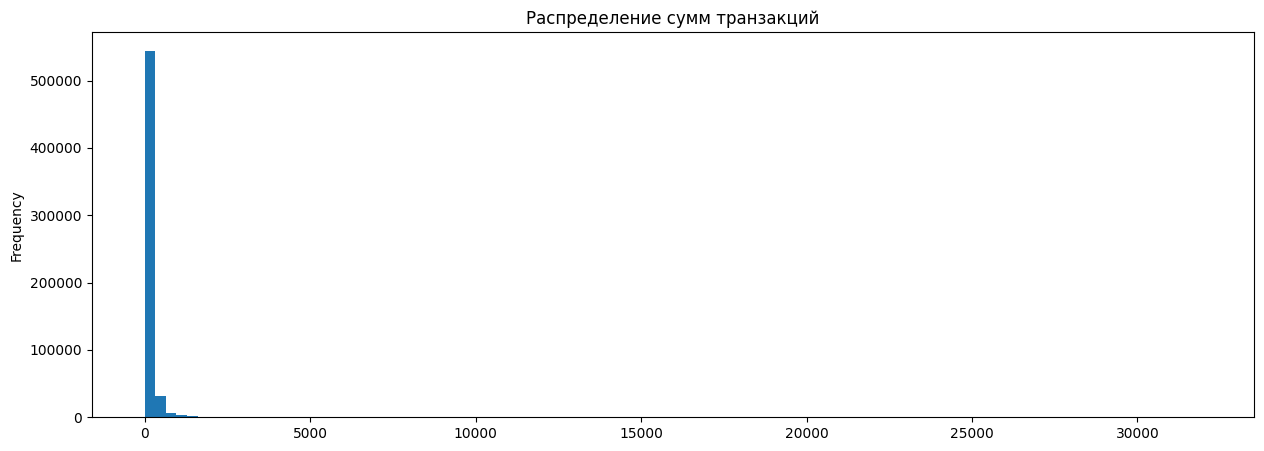

In [20]:
train['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Распределение сумм транзакций')
plt.show()

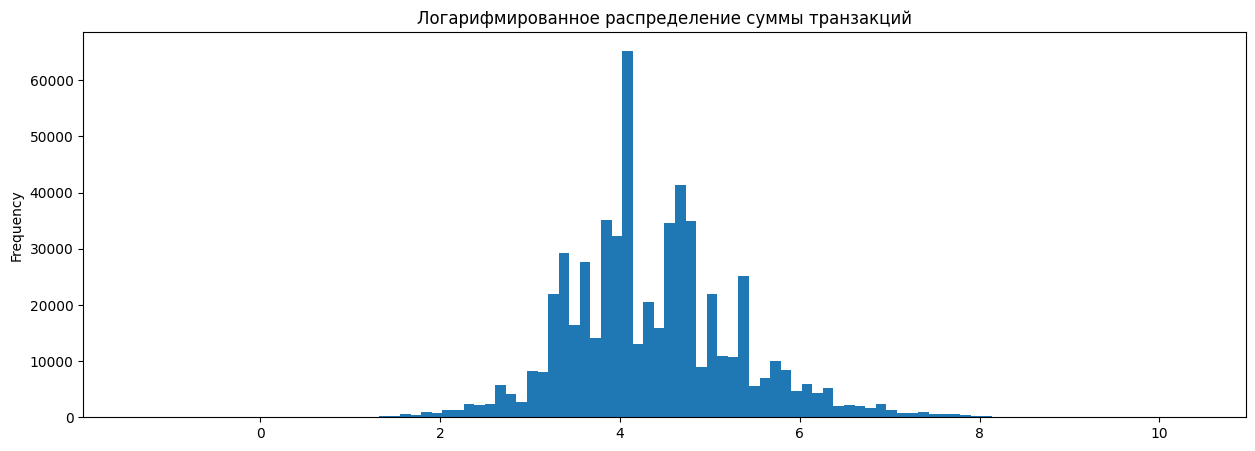

In [21]:
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Логарифмированное распределение суммы транзакций')
plt.show()

In [23]:
print('Средняя сумма "Fraud" транзакции {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Средняя сумма "Non Fraud" транзакции {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Средняя сумма "Fraud" транзакции 149.2448
Средняя сумма "Non Fraud" транзакции 134.5117


Средняя сумма по мошенническим операциям больше

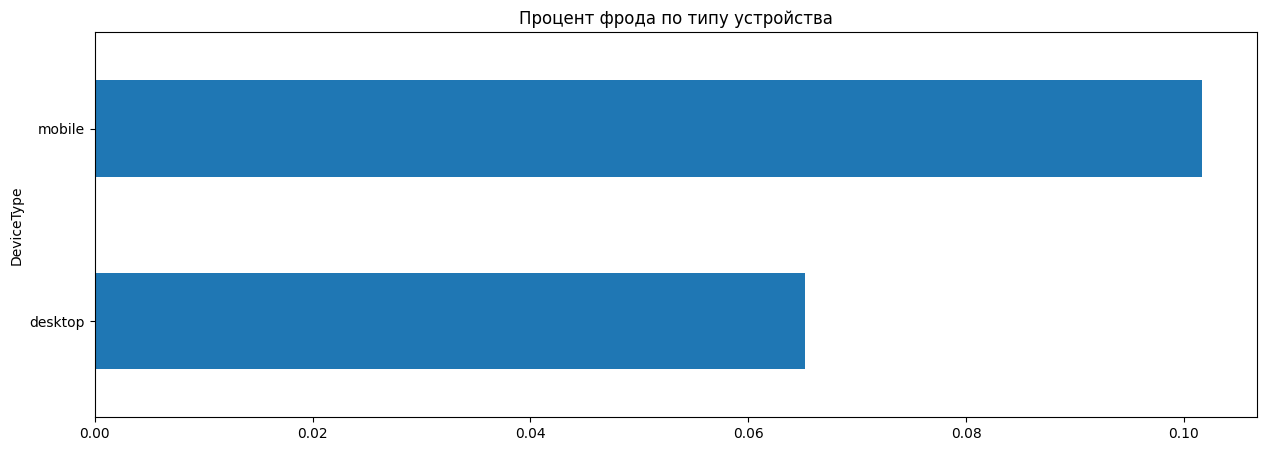

In [24]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Процент фрода по типу устройства')
plt.show()

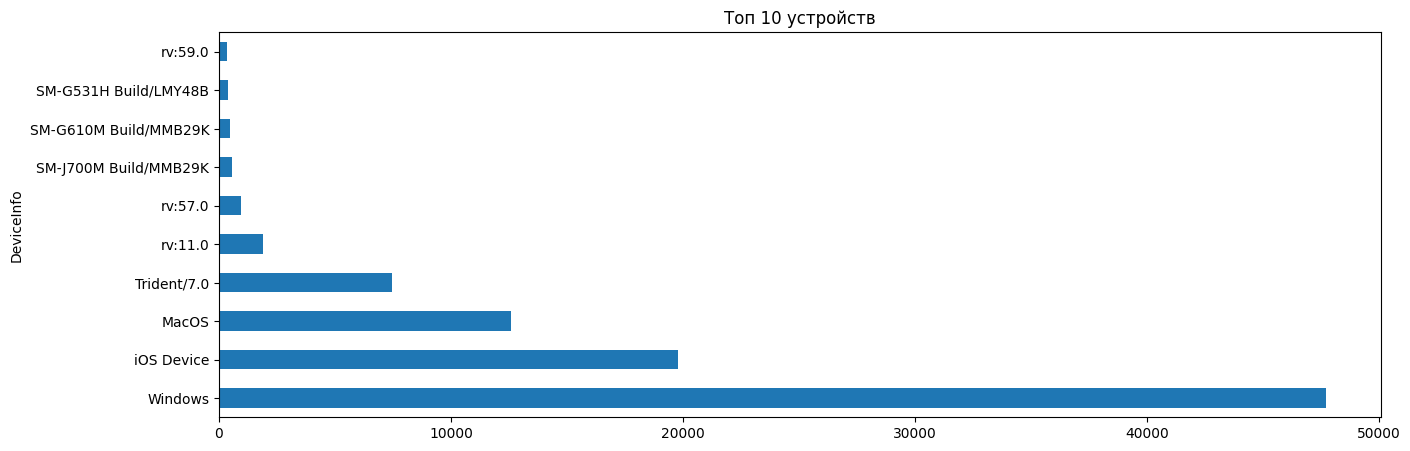

In [25]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(10) \
    .plot(kind='barh', figsize=(15, 5), title='Топ 10 устройств')
plt.show()

In [ ]:
def fraud_datetime(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

    df['dow'] = df['TransactionDT'].dt.dayofweek
    df['hour'] = df['TransactionDT'].dt.hour
    df.drop(['TransactionDT'],axis=1,inplace=True)
    return df

# 3. Моделирование

In [28]:
TARGET = 'isFraud'
RANDOM_STATE = 42
N_THREADS = 4

np.random.seed(RANDOM_STATE)

## Train val split

In [67]:
train, val = train_test_split(
    train,
    test_size=0.2, 
    stratify=train[TARGET], 
    random_state=RANDOM_STATE
)

X_train = train.drop(['TransactionID', 'isFraud'], axis=1)
X_val = val.drop(['TransactionID', 'isFraud'], axis=1)
y_train = train[TARGET].copy()
y_val = val[TARGET].copy()

indices = (train.index.tolist() + val.index.tolist())

print(f'Data splitted. Parts sizes: train = {train.shape}, test = {val.shape}')

train.head()

Data splitted. Parts sizes: train = (472432, 434), test = (118108, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
40809,3027809,0,1008491,100.00,R,6177,399.0,150.0,american express,150.0,...,ie 11.0 for desktop,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Trident/7.0
285886,3272886,0,7008212,29.99,W,7900,345.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104256,3091256,0,2071522,107.95,W,11690,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507860,3494860,0,13299752,241.95,W,2616,327.0,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196382,3183382,0,4412283,117.00,W,13780,298.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
indices = (train.index.tolist() + val.index.tolist())

## LightAutoML Baseline

In [10]:
task = Task(
    'binary',  # required
    loss='logloss',
    metric='auc'
)

roles = {
    'target': TARGET,
    'drop': ['TransactionID']
}

In [15]:
N_FOLDS = 5
TIMEOUT = 60 * 30  # 30 minutes

Simple baseline

In [24]:
automl = TabularAutoML(
    task=task,  # required
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [25]:
%%time
oof_preds = automl.fit_predict(train, roles=roles, verbose=1)

[23:02:08] Stdout logging level is INFO.

[23:02:08] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer

[23:02:08] Task: binary



[23:02:08] Start automl preset with listed constraints:

[23:02:08] - time: 1800.00 seconds

[23:02:08] - CPU: 4 cores

[23:02:08] - memory: 16 GB



[23:02:08] Train data shape: (472432, 434)


[23:02:57] Layer 1 train process start. Time left 1750.53 secs

[23:03:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

[23:06:34] Time limit exceeded after calculating fold 0



[23:06:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9072126491683943

[23:06:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed

[23:06:34] Time left 1534.03 secs



[23:08:29] Selector_LightGBM fitting and predicting completed

[23:09:04] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

[23:11:11] Time limit exceeded after calculating fold 0



[23:11:11] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.96

In [26]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 

	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 


In [27]:
%%time

val_preds = automl.predict(val)
print(f'Prediction for te_data:\n{test_preds}\nShape = {val_preds.shape}')

Prediction for te_data:

array([[4.2660354e-04],

       [3.0546326e-03],

       [1.1868344e-03],

       ...,

       [1.7769694e-02],

       [1.4449594e-02],

       [6.9543414e-05]], dtype=float32)

Shape = (118108, 1)

CPU times: total: 26.9 s

Wall time: 9.75 s


In [28]:
print(f'HOLDOUT score: {roc_auc_score(val["isFraud"].values, val_preds.data[:, 0])}')

HOLDOUT score: 0.967099986004928


Делаем предикты для тестового датафрейма и сабмитим результаты

In [29]:
%%time
preds = automl.predict(test)
sample_submission['isFraud'] = preds.data[:, 0]
sample_submission.to_csv('simple_automl.csv', index=False)

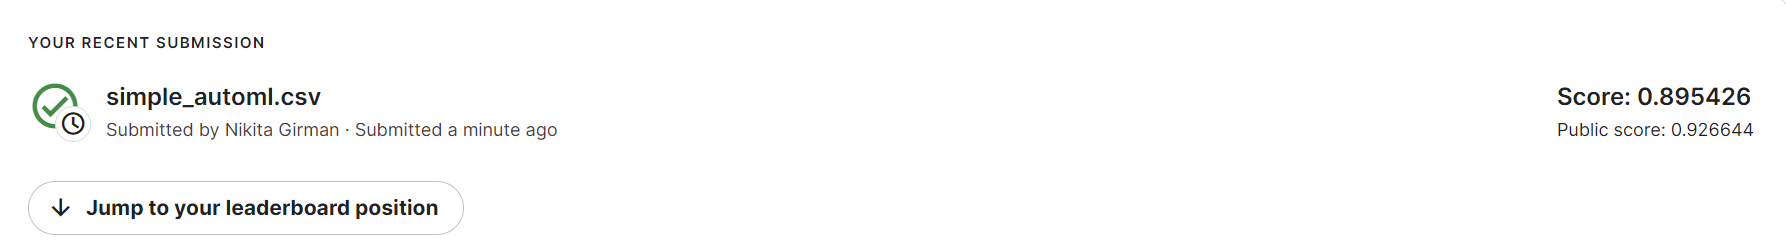

Advanced baseline with different settings

In [16]:
advanced_automl = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params={'use_algos': [['linear_l2', 'rf', 'rf_tuned']]}
)

In [17]:
%%time 
oof_advanced_pred = advanced_automl.fit_predict(train, roles=roles, verbose=1)

[21:48:40] Start automl utilizator with listed constraints:
[21:48:40] - time: 1800.00 seconds
[21:48:40] - CPU: 4 cores
[21:48:40] - memory: 16 GB

[21:48:40] If one preset completes earlier, next preset configuration will be started

[21:48:40] ==================================================
[21:48:40] Start 0 automl preset configuration:
[21:48:40] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[21:48:41] Stdout logging level is INFO.
[21:48:41] Task: binary

[21:48:41] Start automl preset with listed constraints:
[21:48:41] - time: 1800.00 seconds
[21:48:41] - CPU: 4 cores
[21:48:41] - memory: 16 GB

[21:48:41] Train data shape: (472432, 434)

[21:49:41] Layer 1 train process start. Time left 1739.31 secs
[21:50:55] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[21:59:13] Time limit exceeded after calculating fold 0

[21:59:13] Fitting Lvl_0_Pipe_0_Mod_0_RFSklea

In [20]:
%%time

advanced_val_preds = advanced_automl.predict(val)
print(f'Prediction for te_data:\n{advanced_val_preds}\nShape = {advanced_val_preds.shape}')

Prediction for te_data:
array([[0.00762757],
       [0.01371899],
       [0.00937435],
       ...,
       [0.04596214],
       [0.02574252],
       [0.00426269]], dtype=float32)
Shape = (118108, 1)
CPU times: user 31.3 s, sys: 1.6 s, total: 32.9 s
Wall time: 20 s


In [21]:
print(f'HOLDOUT score: {roc_auc_score(val["isFraud"].values, advanced_val_preds.data[:, 0])}')

HOLDOUT score: 0.928722000502379


In [ ]:
%%time
advanced_preds = advanced_automl.predict(test)

In [25]:
sample_submission['isFraud'] = advanced_preds.data[:, 0]
sample_submission.to_csv('advanced_automl.csv', index=False)

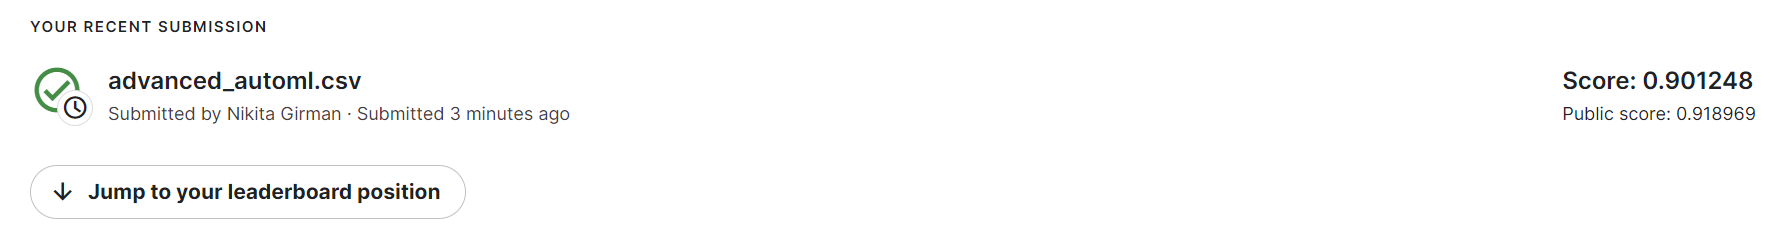